- **Note:** Before running any code cells, please update the paths in the notebook so they point to your local copy of the **UOTReg** folder.

In [1]:
# Change this to the path to your folder
result_folder = '/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/'

In [2]:
import os
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
os.chdir(result_folder)
print("Current working directory:", os.getcwd())

# basic math package
import pandas as pd
import numpy as np

# loading data
import scanpy as sc

# some practical packages
import warnings
warnings.filterwarnings('ignore')
import gc
from IPython.display import clear_output

# packages for DL
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
from torch.distributions import constraints
from tqdm import tqdm, tqdm_notebook
from copy import deepcopy

# package for matrix operation
from sklearn.decomposition import PCA
from sklearn.datasets import make_spd_matrix

# load OT functions
from UOTReg.tools import ewma, freeze, unfreeze
from UOTReg import distributions
from UOTReg.models import FFNN, Seperate_D, Seperate_T, Gnet, Encoder, Discriminator
from UOTReg.tools import tensorDataset, tensorSampler
from UOTReg.tools import weights_init, calculate_moments, calculate_weights, random_sample
from UOTReg.train_models import optimize_T_and_D, optimize_G, optimize_T_and_D_UOT_new


# for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import umap

Current working directory: /Users/binghao/Desktop/Research/OT-singlecell/UOTReg


## Setup data

In [3]:
import scanpy as sc
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 

# Note: this is the top 1000 HVGs of embryoid dataset, already normalized to 1e4 and log1p transformed
embryoid = sc.read(result_folder + "data/timedata/embryoid/embryoid_data.h5ad")
print(embryoid.shape)

(16821, 1000)


In [4]:
# Convert PCA array to Pandas data frame
embryoid_pc = embryoid.obsm['X_pca'][:,0:20]

embryoid_pc_df = pd.DataFrame(
    data=embryoid_pc,
    index=embryoid.obs_names,               # Row index from original AnnData object
    columns=[f"PC{i+1}" for i in range(embryoid_pc.shape[1])]  # Column names as PC1, PC2, ...
)

print(type(embryoid_pc_df))  # Should be <class 'pandas.DataFrame'>
print(embryoid_pc_df.shape)

# get the time snapshots info
cells_meta = embryoid.obs
unique_time = embryoid.obs['time'].unique().to_list()
print(unique_time)

<class 'pandas.core.frame.DataFrame'>
(16821, 20)
['Day 00-03', 'Day 06-09', 'Day 12-15', 'Day 18-21', 'Day 24-27']


In [5]:
Y_time_samplers = []

# get samplers for different time snapshots
for id in unique_time:
    X_k = embryoid_pc_df[embryoid.obs['time'] == id]
    cells_k = cells_meta[cells_meta['time'] == id]
    dataset = tensorDataset(X_k,cells_k)
    print(len(dataset))
    Y_time_samplers.append(tensorSampler(dataset, device="cpu"))

2381
4165
3278
3665
3332


<Figure size 600x200 with 0 Axes>

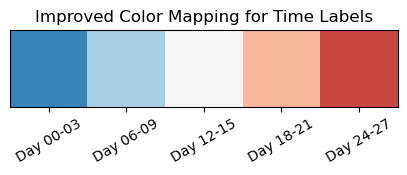

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color gradient with higher contrast
color_palette = sns.color_palette("RdBu_r", n_colors=5)  # Using reversed Red-Blue colormap

# Assign colors to time labels
time_labels = ['Day 00-03', 'Day 06-09', 'Day 12-15', 'Day 18-21', 'Day 24-27']
color_dict = dict(zip(time_labels, color_palette))

# Show the new color mapping
plt.figure(figsize=(6, 2))
sns.palplot(color_palette)
plt.xticks(range(5), time_labels, rotation=30)
plt.title("Improved Color Mapping for Time Labels")
plt.show()

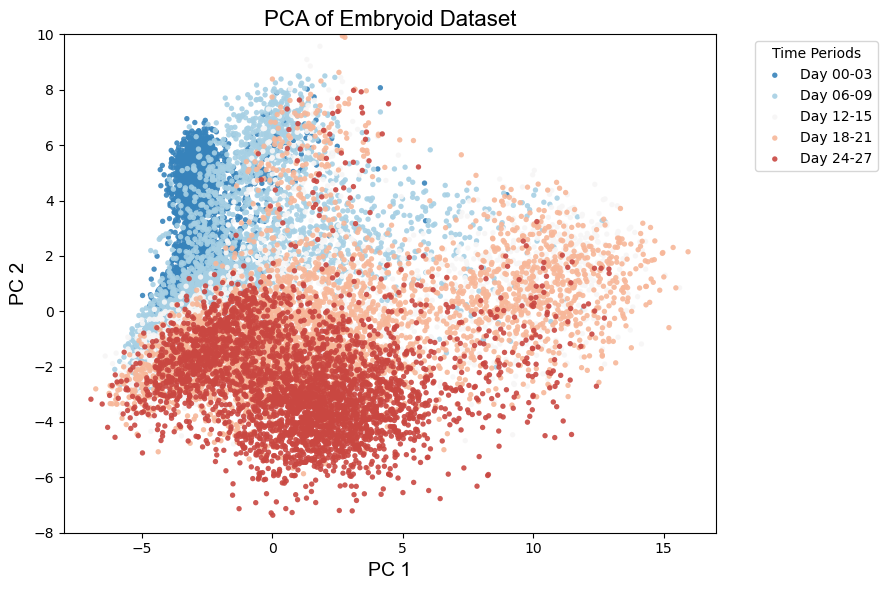

In [8]:
# Extract the first two principal components
pc1 = embryoid.obsm['X_pca'][:, 0]
pc2 = embryoid.obsm['X_pca'][:, 1]

# Customizable parameters
alpha_values = {
    'Day 00-03': 0.9,
    'Day 06-09': 0.9,
    'Day 12-15': 0.9,
    'Day 18-21': 0.9,
    'Day 24-27': 0.9
}
marker_size = 15  # Adjust scatter size
font_family = "Arial"  # Change font family
font_size_label = 14   # Font size for axis labels
font_size_title = 16   # Font size for title

# Allow custom axis limits (change as needed)
x_range = (-8, 17)
y_range = (-8, 10)

plt.figure(figsize=(9, 6))

# Plot each time group with no edge color, ensuring points are fully filled
for label in time_labels:
    subset = embryoid.obs['time'] == label
    plt.scatter(
        pc1[subset], 
        pc2[subset], 
        c=[color_dict[label]], 
        label=label, 
        s=marker_size,  # Adjustable marker size
        alpha=alpha_values[label], 
        edgecolors='none'  # Ensure no border for scatter points
    )

# Move the legend outside the plot
plt.legend(title="Time Periods", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set axis limits
plt.xlim(x_range)
plt.ylim(y_range)

# Customize font styles
plt.xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
plt.ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
plt.title("PCA of Embryoid Dataset", fontsize=font_size_title, fontfamily=font_family)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()


## Estimated distributions

In [9]:
# loading the learned generators
size = 256
DIM = 20
dropout_rate = 0.05
G1 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G2 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G3 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G4 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G5 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G6 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G7 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
Z_sampler = distributions.StandardNormalSampler(dim=DIM, device="cpu")

print('G params:', np.sum([np.prod(p.shape) for p in G2.parameters()]))

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 

G1.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day4_25_tau5_new2.pth"))
G2.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day7_25_tau5_new2.pth"))
G3.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day10_25_tau5_new2.pth"))
G4.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day13_25_tau5_new2.pth"))
G5.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day16_25_tau5_new2.pth"))
G6.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day19_25_tau5_new2.pth"))
G7.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day22_25_tau5_new2.pth"))

G params: 207892


<All keys matched successfully>

In [10]:
# check learned distributions

G1.eval(); G2.eval(); G3.eval(); G4.eval(); G5.eval(); G6.eval(); G7.eval()
data_num = 2000
data_learned1 = G1(Z_sampler.sample(data_num)).detach().numpy()
data_learned2 = G2(Z_sampler.sample(data_num)).detach().numpy()
data_learned3 = G3(Z_sampler.sample(data_num)).detach().numpy()
data_learned4 = G4(Z_sampler.sample(data_num)).detach().numpy()
data_learned5 = G5(Z_sampler.sample(data_num)).detach().numpy()
data_learned6 = G6(Z_sampler.sample(data_num)).detach().numpy()
data_learned7 = G7(Z_sampler.sample(data_num)).detach().numpy()

# Combine original and new time labels in chronological order
time_labels = [
    'Day 00-03', 'Day 03-06 (predicted)', 'Day 06-09 (predicted)', 'Day 09-12 (predicted)', 
    'Day 12-15 (predicted)', 'Day 15-18 (predicted)', 'Day 18-21 (predicted)', 'Day 21-24 (predicted)', 'Day 24-27'
]

# Define data sources accordingly (assuming you already have the data)
data_dict_ori = {
    'Day 00-03': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 00-03'],
    'Day 06-09': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 06-09'],
    'Day 12-15': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 12-15'],
    'Day 18-21': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 18-21'],
    'Day 24-27': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 24-27']
}

data_dict = {
    'Day 00-03': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 00-03'],
    'Day 03-06 (predicted)': data_learned1,
    'Day 06-09 (predicted)': data_learned2,
    'Day 09-12 (predicted)': data_learned3,
    'Day 12-15 (predicted)': data_learned4,
    'Day 15-18 (predicted)': data_learned5,
    'Day 18-21 (predicted)': data_learned6,
    'Day 21-24 (predicted)': data_learned7,
    'Day 24-27': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 24-27']
}

<Figure size 800x200 with 0 Axes>

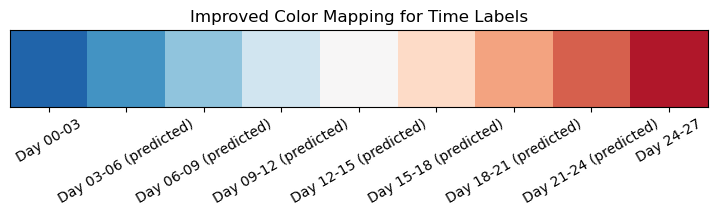

In [11]:
# Generate a higher contrast and saturation color gradient
color_palette = sns.color_palette("RdBu_r", n_colors=9)

# Assign colors to each time label
color_dict = dict(zip(time_labels, color_palette))

# Show the updated color mapping
plt.figure(figsize=(8, 2))
sns.palplot(color_palette)
plt.xticks(range(9), time_labels, rotation=30)
plt.title("Improved Color Mapping for Time Labels")
plt.show()


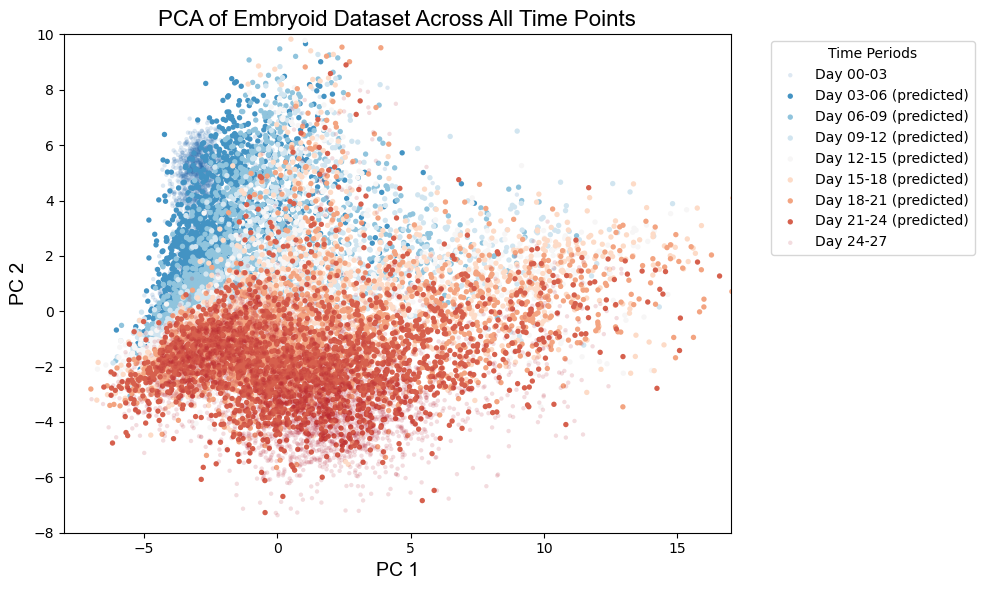

In [12]:
# Define visualization parameters
marker_size = 15  # Adjust marker size
font_family = "Arial"  # Customize font
font_size_label = 14  # Axis labels font size
font_size_title = 16  # Title font size
alpha_values = 1  # General transparency setting

# Scatter plot with the combined datasets
x_range = (-8, 17)
y_range = (-8, 10)

plt.figure(figsize=(10, 6))

z_orders = {
    'Day 00-03': 1,
    'Day 06-09 (predicted)': 7,
    'Day 12-15 (predicted)': 9,
    'Day 18-21 (predicted)': 11,
    'Day 24-27': 17,
    'Day 03-06 (predicted)': 6,
    'Day 09-12 (predicted)': 8,
    'Day 15-18 (predicted)': 10,
    'Day 21-24 (predicted)': 12
}

marker_sizes = {
    'Day 00-03': 10,
    'Day 06-09 (predicted)': 15,
    'Day 12-15 (predicted)': 15,
    'Day 18-21 (predicted)': 15,
    'Day 24-27': 10,
    'Day 03-06 (predicted)': 15,
    'Day 09-12 (predicted)': 15,
    'Day 15-18 (predicted)': 15,
    'Day 21-24 (predicted)': 15
}

alpha_values = {
    'Day 00-03': 0.15,
    'Day 06-09 (predicted)': 1,
    'Day 12-15 (predicted)': 1,
    'Day 18-21 (predicted)': 1,
    'Day 24-27': 0.15,
    'Day 03-06 (predicted)': 1,
    'Day 09-12 (predicted)': 1,
    'Day 15-18 (predicted)': 1,
    'Day 21-24 (predicted)': 1
}

for label in time_labels:
    data = data_dict[label]
    plt.scatter(
        data[:, 0], data[:, 1], 
        c=[color_dict[label]], 
        label=label, 
        s=marker_sizes[label],  # Scatter point size
        alpha=alpha_values[label], 
        edgecolors='none',  # Ensure fully filled points
        zorder = z_orders[label]
    )

# Customize plot labels and title
plt.xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
plt.ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
plt.title("PCA of Embryoid Dataset Across All Time Points", fontsize=font_size_title, fontfamily=font_family)

# Move the legend outside the plot
plt.legend(title="Time Periods", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set axis limits
plt.xlim(x_range)
plt.ylim(y_range)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()


### Visualization: estimated distributions

<Figure size 600x200 with 0 Axes>

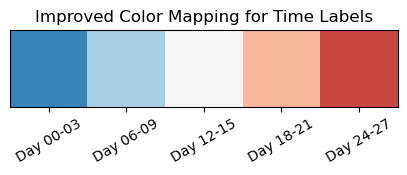

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color gradient with higher contrast
color_palette = sns.color_palette("RdBu_r", n_colors=5)  # Using reversed Red-Blue colormap

# Assign colors to time labels
time_labels = ['Day 00-03', 'Day 06-09', 'Day 12-15', 'Day 18-21', 'Day 24-27']
color_dict = dict(zip(time_labels, color_palette))

# Show the new color mapping
plt.figure(figsize=(6, 2))
sns.palplot(color_palette)
plt.xticks(range(5), time_labels, rotation=30)
plt.title("Improved Color Mapping for Time Labels")
plt.show()

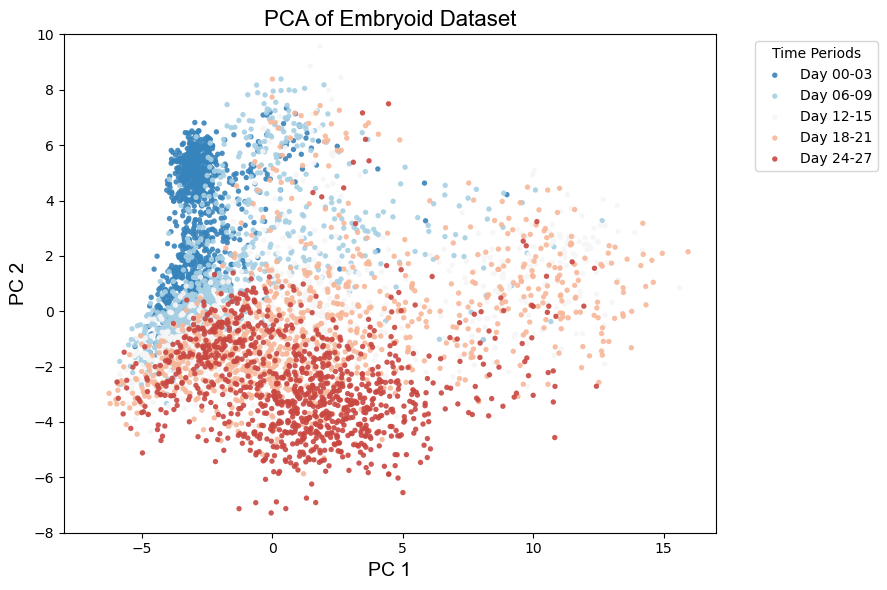

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the first two principal components
pc1 = embryoid.obsm['X_pca'][:, 0]
pc2 = embryoid.obsm['X_pca'][:, 1]

# ----- settings -----
alpha_values = {
    'Day 00-03': 0.9,
    'Day 06-09': 0.9,
    'Day 12-15': 0.9,
    'Day 18-21': 0.9,
    'Day 24-27': 0.9
}
marker_size = 15
font_family = "Arial"
font_size_label = 14
font_size_title = 16
x_range = (-8, 17)
y_range = (-8, 10)

# reproducible subsampling
rng = np.random.default_rng(42)
n_per_label = 1000  # <- subsample size

plt.figure(figsize=(9, 6))

for label in time_labels:
    # indices of cells with this label
    idx_all = np.where(embryoid.obs['time'].values == label)[0]
    # subsample exactly 500 without replacement
    idx = rng.choice(idx_all, n_per_label, replace=False)

    plt.scatter(
        pc1[idx],
        pc2[idx],
        c=[color_dict[label]],
        label=label,
        s=marker_size,
        alpha=alpha_values[label],
        edgecolors='none'
    )

plt.legend(title="Time Periods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(x_range); plt.ylim(y_range)
plt.xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
plt.ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
plt.title("PCA of Embryoid Dataset", fontsize=font_size_title, fontfamily=font_family)
plt.tight_layout()
plt.show()


<Figure size 800x200 with 0 Axes>

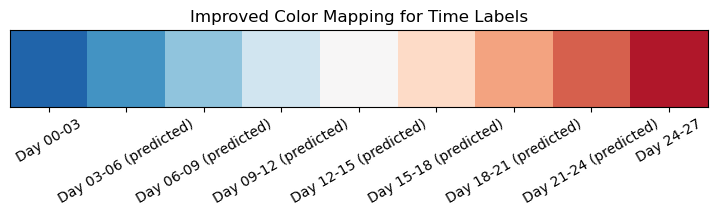

In [15]:
time_labels = [
    'Day 00-03', 'Day 03-06 (predicted)', 'Day 06-09 (predicted)', 'Day 09-12 (predicted)', 
    'Day 12-15 (predicted)', 'Day 15-18 (predicted)', 'Day 18-21 (predicted)', 'Day 21-24 (predicted)', 'Day 24-27'
]

# Generate a higher contrast and saturation color gradient
color_palette = sns.color_palette("RdBu_r", n_colors=9)

# Assign colors to each time label
color_dict = dict(zip(time_labels, color_palette))

# Show the updated color mapping
plt.figure(figsize=(8, 2))
sns.palplot(color_palette)
plt.xticks(range(9), time_labels, rotation=30)
plt.title("Improved Color Mapping for Time Labels")
plt.show()


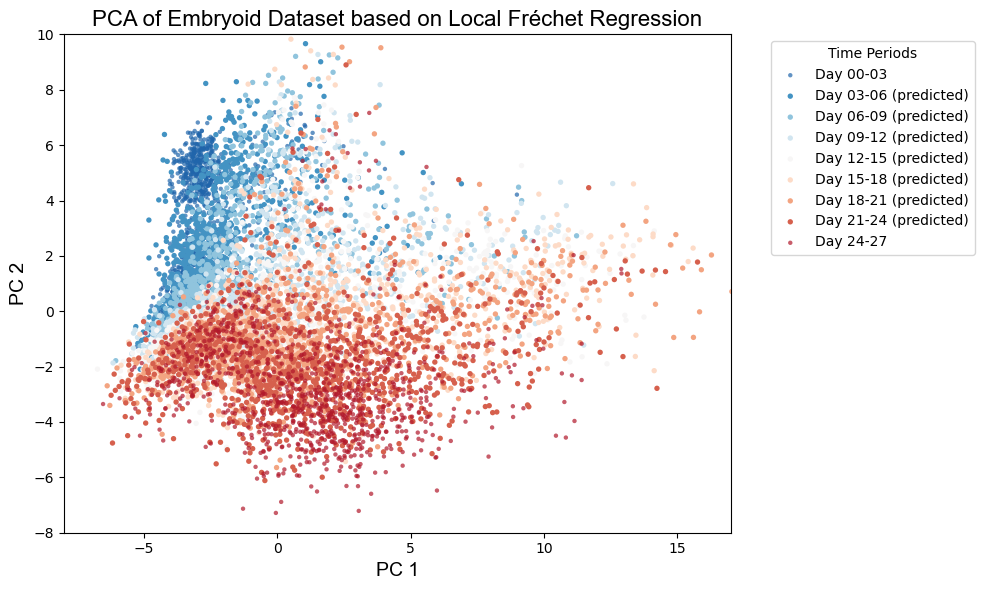

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# --- config (as you had) ---
marker_size = 15
font_family = "Arial"
font_size_label = 14
font_size_title = 16
x_range = (-8, 17)
y_range = (-8, 10)

z_orders = {
    'Day 00-03': 1,
    'Day 06-09 (predicted)': 7,
    'Day 12-15 (predicted)': 9,
    'Day 18-21 (predicted)': 11,
    'Day 24-27': 17,
    'Day 03-06 (predicted)': 6,
    'Day 09-12 (predicted)': 8,
    'Day 15-18 (predicted)': 10,
    'Day 21-24 (predicted)': 12
}
marker_sizes = {
    'Day 00-03': 10,
    'Day 06-09 (predicted)': 15,
    'Day 12-15 (predicted)': 15,
    'Day 18-21 (predicted)': 15,
    'Day 24-27': 10,
    'Day 03-06 (predicted)': 15,
    'Day 09-12 (predicted)': 15,
    'Day 15-18 (predicted)': 15,
    'Day 21-24 (predicted)': 15
}
alpha_values = {
    'Day 00-03': 0.7,
    'Day 06-09 (predicted)': 1,
    'Day 12-15 (predicted)': 1,
    'Day 18-21 (predicted)': 1,
    'Day 24-27': 0.7,
    'Day 03-06 (predicted)': 1,
    'Day 09-12 (predicted)': 1,
    'Day 15-18 (predicted)': 1,
    'Day 21-24 (predicted)': 1
}

# --- subsample & plot ---
rng = np.random.default_rng(42)   # reproducible
n_per_label = 1000                 # guaranteed available per label

plt.figure(figsize=(10, 6))

for label in time_labels:
    data = data_dict[label]               # shape: (N, 2) or (N, d) but we're using [:, :2]
    idx = rng.choice(len(data), n_per_label, replace=False)
    subs = data[idx, :2]                  # use first two PCs if data has >2 cols

    plt.scatter(
        subs[:, 0], subs[:, 1],
        c=[color_dict[label]],
        label=label,
        s=marker_sizes[label],
        alpha=alpha_values[label],
        edgecolors='none',
        zorder=z_orders[label]
    )

plt.xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
plt.ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
plt.title("PCA of Embryoid Dataset based on Local Fréchet Regression", fontsize=font_size_title, fontfamily=font_family)
plt.legend(title="Time Periods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(x_range); plt.ylim(y_range)
plt.tight_layout()
plt.show()


## Construct New Samplers

In [17]:
Y_time_samplers = []

# get samplers for different time snapshots
for id in unique_time:
    X_k = embryoid_pc_df[embryoid.obs['time'] == id]
    cells_k = cells_meta[cells_meta['time'] == id]
    dataset = tensorDataset(X_k,cells_k)
    print(len(dataset))
    Y_time_samplers.append(tensorSampler(dataset, device="cpu"))

2381
4165
3278
3665
3332


In [18]:
# Construct Y_time_samplers_learned with X_k as a pandas DataFrame
import pandas as pd
import torch

torch.manual_seed(0)

day_labels = [4, 7, 10, 13, 16, 19, 22]
generators = [G1, G2, G3, G4, G5, G6, G7]
n_per_day  = 4000
DIM        = Z_sampler.dim if hasattr(Z_sampler, "dim") else 20   # keep DIM consistent
device     = torch.device("cpu")

# Choose column names for the DataFrame
try:
    X_cols = list(embryoid_pc_df.columns)[:DIM]
    if len(X_cols) != DIM:
        raise ValueError("embryoid_pc_df has incompatible number of columns.")
except Exception:
    X_cols = [f"pc{i+1}" for i in range(DIM)]

for G in generators:
    G.eval()

Y_time_samplers_learned = []
for day, G in zip(day_labels, generators):
    with torch.no_grad():
        Z_t   = Z_sampler.sample(n_per_day)                   # torch [n, DIM]
        X_t   = G(Z_t).detach().to(device).float()            # torch [n, DIM]
        X_np  = X_t.cpu().numpy()                             # numpy [n, DIM]
        X_k   = pd.DataFrame(X_np, columns=X_cols)            # <-- pandas DataFrame

    cells_k = pd.DataFrame({
        "cell_id": [f"d{day}_{i}" for i in range(n_per_day)],
        "time":    day,
        "day":     day
    })

    dataset_k = tensorDataset(X_k, cells_k)
    sampler_k = tensorSampler(dataset_k, device="cpu")
    Y_time_samplers_learned.append(sampler_k)

    print(f"Day {day}: dataset size = {len(dataset_k)}, X_k shape = {X_k.shape}, columns = {X_k.columns[:3].tolist()}...")


Day 4: dataset size = 4000, X_k shape = (4000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 7: dataset size = 4000, X_k shape = (4000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 10: dataset size = 4000, X_k shape = (4000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 13: dataset size = 4000, X_k shape = (4000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 16: dataset size = 4000, X_k shape = (4000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 19: dataset size = 4000, X_k shape = (4000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 22: dataset size = 4000, X_k shape = (4000, 20), columns = ['PC1', 'PC2', 'PC3']...


In [19]:
Y_time_samplers_mix = [Y_time_samplers[0], *Y_time_samplers_learned, Y_time_samplers[-1]]

## Visualization: Trajectories

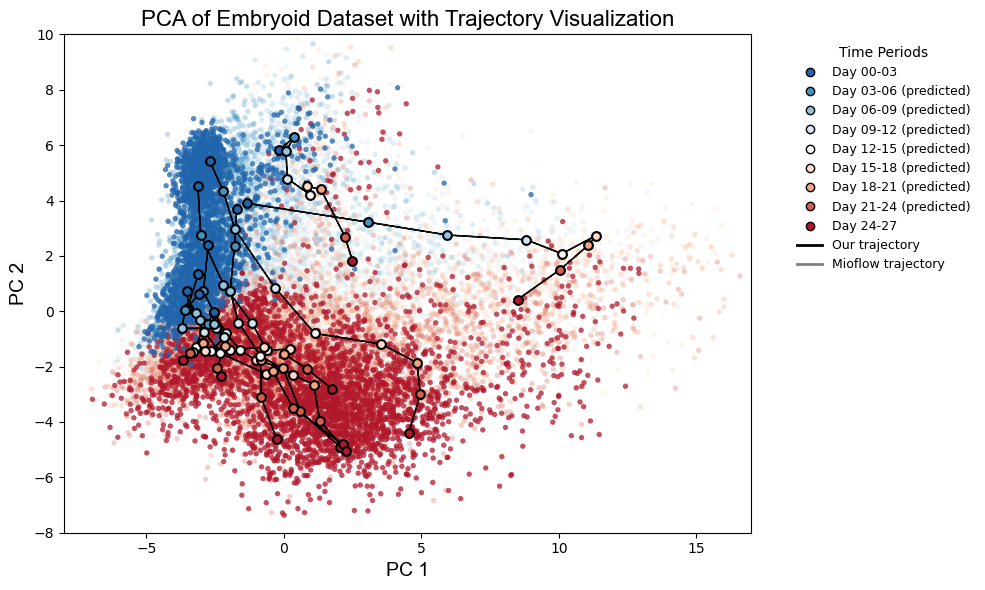

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Generate a higher contrast and saturation color gradient
color_palette = sns.color_palette("RdBu_r", n_colors=9)

# Assign colors to each time label
color_dict = dict(zip(time_labels, color_palette))

# Load the transport maps for all 8 steps

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
T_maps = [torch.load(result_folder + f"results/dynamics/embryoid/Trajectories/reg50/T_map_{i+1}_to_{i+2}.pt") for i in range(8)]

# Sample 10 points from Ysamplers_new[0]
num_points = 10
data = Y_time_samplers_mix[0].sample(1000)
indices = np.random.choice(data.shape[0], num_points, replace=False)
data_selected = data[indices]

# Convert data to numpy for visualization
trajectory = [data_selected.detach().numpy()]
trajectory_time_labels = ['Day 00-03','Day 03-06 (predicted)','Day 06-09 (predicted)','Day 09-12 (predicted)','Day 12-15 (predicted)','Day 15-18 (predicted)',
                'Day 18-21 (predicted)', 'Day 21-24 (predicted)', 'Day 24-27']
trajectory_colors = plt.cm.viridis(np.linspace(0, 1, 10))

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)

# Apply each transformation step and store the results
current_data = data_selected.clone()
for Tparam in T_maps:
    T.load_state_dict(Tparam)
    T.eval()
    current_data = T(current_data)  # Apply transformation
    trajectory.append(current_data.detach().numpy())

# Convert trajectory to a numpy array for plotting
trajectory = np.array(trajectory)  # Shape: (9, num_points, feature_dim)
traj_reg = trajectory

# Define visualization parameters
marker_size = 15
font_family = "Arial"
font_size_label = 14
font_size_title = 16

x_range = (-8, 17)
y_range = (-8, 10)

z_orders = {
    'Day 00-03': 10,
    'Day 06-09 (predicted)': 2,
    'Day 12-15 (predicted)': 4,
    'Day 18-21 (predicted)': 6,
    'Day 24-27': 9,
    'Day 03-06 (predicted)': 1,
    'Day 09-12 (predicted)': 3,
    'Day 15-18 (predicted)': 5,
    'Day 21-24 (predicted)': 7
}

marker_sizes = {
    'Day 00-03': 15,
    'Day 06-09 (predicted)': 15,
    'Day 12-15 (predicted)': 15,
    'Day 18-21 (predicted)': 15,
    'Day 24-27': 15,
    'Day 03-06 (predicted)': 15,
    'Day 09-12 (predicted)': 15,
    'Day 15-18 (predicted)': 15,
    'Day 21-24 (predicted)': 15
}

alpha_values = {
    'Day 00-03': 0.75,
    'Day 06-09 (predicted)': 0.3,
    'Day 12-15 (predicted)': 0.3,
    'Day 18-21 (predicted)': 0.3,
    'Day 24-27': 0.75,
    'Day 03-06 (predicted)': 0.3,
    'Day 09-12 (predicted)': 0.3,
    'Day 15-18 (predicted)': 0.3,
    'Day 21-24 (predicted)': 0.3
}

# Create the plot
plt.figure(figsize=(10, 6))

# Plot original dataset with different colors
for label in time_labels:
    data = data_dict[label]
    plt.scatter(
        data[:, 0], data[:, 1], 
        c=[color_dict[label]], 
        label=label, 
        s=marker_sizes[label],  
        alpha=alpha_values[label], 
        edgecolors='none',
        zorder=z_orders[label]
    )
    
# Plot sampled points and their trajectories with higher z-order
# 1,7,9 ,3(potentially)  
for i in range(current_data.shape[0]):
    # traj_color = trajectory_colors[i]  # Assign unique color to each trajectory
    traj_color = "black"

    for j in range(len(trajectory) - 1):
        # Plot line segments between consecutive steps
        plt.plot([trajectory[j, i, 0], trajectory[j + 1, i, 0]], 
                 [trajectory[j, i, 1], trajectory[j + 1, i, 1]], 
                 linestyle='--', color=traj_color, linewidth=1, alpha=0.8, zorder=10)  # Higher z-order for lines

        # Add arrow to indicate direction
        plt.arrow(trajectory[j, i, 0], trajectory[j, i, 1],
                  trajectory[j + 1, i, 0] - trajectory[j, i, 0],
                  trajectory[j + 1, i, 1] - trajectory[j, i, 1],
                  color=traj_color, alpha=0.9, head_width=0.1, head_length=0.2, zorder=11)

        # Add intermediate points with corresponding color and black border
        step_label = trajectory_time_labels[j]  # Get the corresponding time label
        plt.scatter(trajectory[j, i, 0], trajectory[j, i, 1], 
                    color=[color_dict[step_label]],  # Assign color based on time point
                    s=40, edgecolors='black', linewidth=1.5, zorder=12)

    # Plot the last point in the trajectory with its corresponding color
    plt.scatter(trajectory[-1, i, 0], trajectory[-1, i, 1], 
                color=[color_dict[trajectory_time_labels[-1]]],  
                s=40, edgecolors='black', linewidth=1.5, zorder=12)

# Customize plot labels and title
plt.xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
plt.ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
plt.title("PCA of Embryoid Dataset with Trajectory Visualization", fontsize=font_size_title, fontfamily=font_family)

# Move the legend outside the plot
# Custom legend elements using Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 00-03'], markersize=6, label='Day 00-03'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 03-06 (predicted)'], markersize=6, label='Day 03-06 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 06-09 (predicted)'], markersize=6, label='Day 06-09 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 09-12 (predicted)'], markersize=6, label='Day 09-12 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 12-15 (predicted)'], markersize=6, label='Day 12-15 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 15-18 (predicted)'], markersize=6, label='Day 15-18 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 18-21 (predicted)'], markersize=6, label='Day 18-21 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 21-24 (predicted)'], markersize=6, label='Day 21-24 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 24-27'], markersize=6, label='Day 24-27'),
    Line2D([0], [0], color='black', linewidth=2, label='Our trajectory'),
    Line2D([0], [0], color='gray', linewidth=2, label='Mioflow trajectory')
]

# Add custom legend outside the plot
plt.legend(
    handles=legend_elements, 
    title="Time Periods", 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    frameon=False,
    fontsize=9
)

# Set axis limits
plt.xlim(x_range)
plt.ylim(y_range)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()

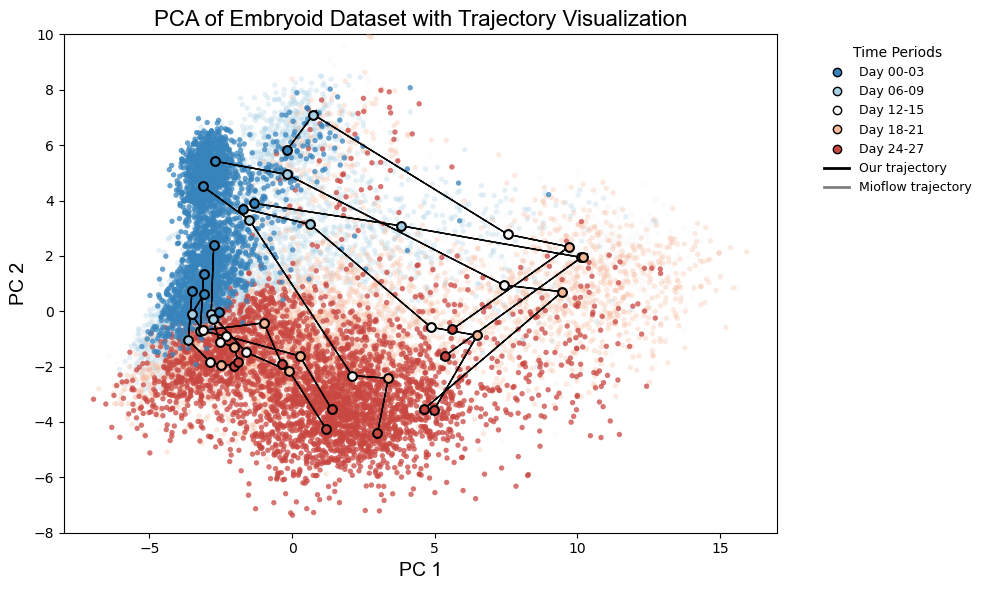

In [21]:
# maps from direct composing

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Generate a higher contrast and saturation color gradient
color_palette = sns.color_palette("RdBu_r", n_colors=5)

trajectory_time_labels = ['Day 00-03','Day 06-09', 'Day 12-15', 'Day 18-21', 'Day 24-27']
# Assign colors to each time label
color_dict = dict(zip(trajectory_time_labels, color_palette))

# Load the transport maps for all 8 steps
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
T_maps = [torch.load(result_folder + f"results/dynamics/embryoid/Trajectories/direct/T_map_{i+1}_to_{i+2}.pt") for i in range(4)]

# Sample 10 points from Ysamplers_new[0]
num_points =10
data = Y_time_samplers_mix[0].sample(1000)
indices = np.random.choice(data.shape[0], num_points, replace=False)
# data_selected = data[indices] # using the same initial points

# Convert data to numpy for visualization
trajectory = [data_selected.detach().numpy()]
trajectory_time_labels = ['Day 00-03','Day 06-09', 'Day 12-15', 'Day 18-21', 'Day 24-27']
trajectory_colors = plt.cm.viridis(np.linspace(0, 1, 6))

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)

# Apply each transformation step and store the results
current_data = data_selected.clone()
for Tparam in T_maps:
    T.load_state_dict(Tparam)
    T.eval()
    current_data = T(current_data)  # Apply transformation
    trajectory.append(current_data.detach().numpy())

# Convert trajectory to a numpy array for plotting
trajectory = np.array(trajectory)  # Shape: (9, num_points, feature_dim)
traj_direct = trajectory

# Define visualization parameters
marker_size = 15
font_family = "Arial"
font_size_label = 14
font_size_title = 16

x_range = (-8, 17)
y_range = (-8, 10)

z_orders = {
    'Day 00-03': 10,
    'Day 06-09': 2,
    'Day 12-15': 4,
    'Day 18-21': 6,
    'Day 24-27': 9
}

marker_sizes = {
    'Day 00-03': 15,
    'Day 06-09': 15,
    'Day 12-15': 15,
    'Day 18-21': 15,
    'Day 24-27': 15
}

alpha_values = {
    'Day 00-03': 0.75,
    'Day 06-09': 0.3,
    'Day 12-15': 0.3,
    'Day 18-21': 0.3,
    'Day 24-27': 0.75
}

# Create the plot
plt.figure(figsize=(10, 6))

# Plot original dataset with different colors
for label in trajectory_time_labels:
    data = data_dict_ori[label]
    plt.scatter(
        data[:, 0], data[:, 1], 
        c=[color_dict[label]], 
        label=label, 
        s=marker_sizes[label],  
        alpha=alpha_values[label], 
        edgecolors='none',
        zorder=z_orders[label]
    )
    
# Plot sampled points and their trajectories with higher z-order
# 1,7,9 ,3(potentially)  
for i in range(current_data.shape[0]):
    # traj_color = trajectory_colors[i]  # Assign unique color to each trajectory
    traj_color = "black"

    for j in range(len(trajectory) - 1):
        # Plot line segments between consecutive steps
        plt.plot([trajectory[j, i, 0], trajectory[j + 1, i, 0]], 
                 [trajectory[j, i, 1], trajectory[j + 1, i, 1]], 
                 linestyle='--', color=traj_color, linewidth=1, alpha=0.8, zorder=10)  # Higher z-order for lines

        # Add arrow to indicate direction
        plt.arrow(trajectory[j, i, 0], trajectory[j, i, 1],
                  trajectory[j + 1, i, 0] - trajectory[j, i, 0],
                  trajectory[j + 1, i, 1] - trajectory[j, i, 1],
                  color=traj_color, alpha=0.9, head_width=0.1, head_length=0.2, zorder=11)

        # Add intermediate points with corresponding color and black border
        step_label = trajectory_time_labels[j]  # Get the corresponding time label
        plt.scatter(trajectory[j, i, 0], trajectory[j, i, 1], 
                    color=[color_dict[step_label]],  # Assign color based on time point
                    s=40, edgecolors='black', linewidth=1.5, zorder=12)

    # Plot the last point in the trajectory with its corresponding color
    plt.scatter(trajectory[-1, i, 0], trajectory[-1, i, 1], 
                color=[color_dict[trajectory_time_labels[-1]]],  
                s=40, edgecolors='black', linewidth=1.5, zorder=12)

# Customize plot labels and title
plt.xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
plt.ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
plt.title("PCA of Embryoid Dataset with Trajectory Visualization", fontsize=font_size_title, fontfamily=font_family)

# Move the legend outside the plot
# Custom legend elements using Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 00-03'], markersize=6, label='Day 00-03'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 06-09'], markersize=6, label='Day 06-09'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 12-15'], markersize=6, label='Day 12-15'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 18-21'], markersize=6, label='Day 18-21'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 24-27'], markersize=6, label='Day 24-27'),
    Line2D([0], [0], color='black', linewidth=2, label='Our trajectory'),
    Line2D([0], [0], color='gray', linewidth=2, label='Mioflow trajectory')
]

# Add custom legend outside the plot
plt.legend(
    handles=legend_elements, 
    title="Time Periods", 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    frameon=False,
    fontsize=9
)

# Set axis limits
plt.xlim(x_range)
plt.ylim(y_range)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()

### Visualization: Trajectories

In [22]:
import pickle

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
with open(result_folder+"results/dynamics/embryoid/initial_embryoid50.pkl", "rb") as f:
    initial_embryoid = pickle.load(f)

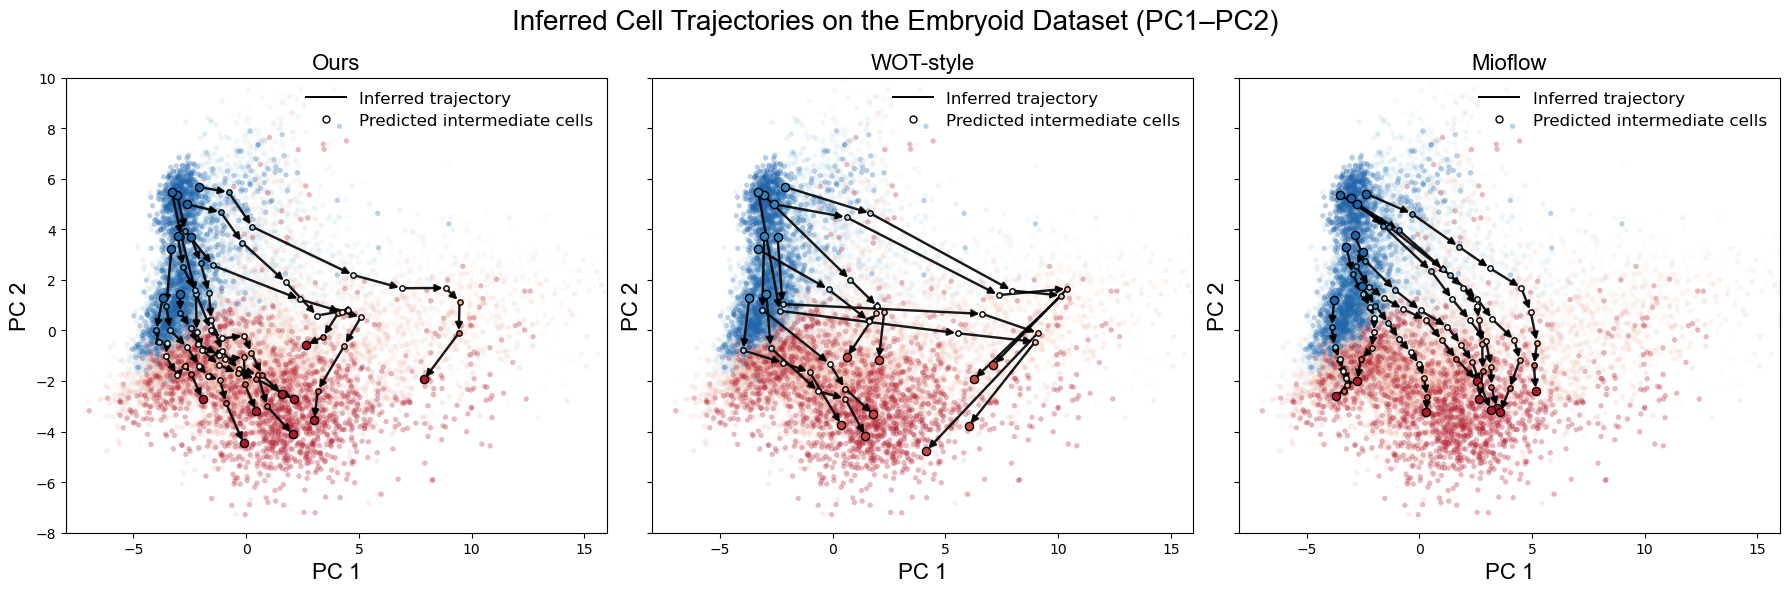

In [23]:
# --- Imports & setup ---
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
import seaborn as sns

# one small helper
def add_panel_legend(ax, fontsize=11, loc="upper right"):
    handles = [
        Line2D([0, 1], [0, 0], color='k', lw=1.4,
               label="Inferred trajectory"),
        Line2D([0], [0], marker='o', color='k', lw=0,
               markerfacecolor='white', markeredgecolor='black',
               markersize=5, label="Predicted intermediate cells"),
    ]
    ax.legend(handles=handles, loc=loc, frameon=False,
              fontsize=fontsize, handlelength=2.4,
              borderpad=0.3, labelspacing=0.4)

# ----------------------------
# Colors for background scatter (same as your code)
# ----------------------------
color_palette = sns.color_palette("RdBu_r", n_colors=9)          # for 9 time labels
color_dict    = dict(zip(time_labels, color_palette))            # needs time_labels in scope

# For the 5-step direct view
color_palette_2 = sns.color_palette("RdBu_r", n_colors=5)
trajectory_time_labels_2 = ['Day 00-03','Day 06-09','Day 12-15','Day 18-21','Day 24-27']
color_dict_2 = dict(zip(trajectory_time_labels_2, color_palette_2))

# ----------------------------
# Load transport maps and build trajectory_1 (regression, 9 steps) and trajectory_2 (direct, 5 steps)
# ----------------------------

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
T_maps  = [torch.load(result_folder + f"results/dynamics/embryoid/Trajectories/reg50/T_map_{i+1}_to_{i+2}.pt")   for i in range(8)]
T_maps2 = [torch.load(result_folder + f"results/dynamics/embryoid/Trajectories/direct50/T_map_{i+1}_to_{i+2}.pt") for i in range(4)]

# Use your initial points (N, 20)
arr = np.concatenate(initial_embryoid, axis=0)
data_selected = torch.from_numpy(arr).float()      # (N, 20)

# 9-step labels (match your background keys)
trajectory_time_labels = [
    'Day 00-03','Day 03-06 (predicted)','Day 06-09 (predicted)','Day 09-12 (predicted)',
    'Day 12-15 (predicted)','Day 15-18 (predicted)','Day 18-21 (predicted)',
    'Day 21-24 (predicted)','Day 24-27'
]

# Build trajectory_1 (regression; 9 steps)
T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)
trajectory = [data_selected.detach().numpy()]
current_data = data_selected.clone()
for Tparam in T_maps:
    T.load_state_dict(Tparam); T.eval()
    current_data = T(current_data)
    trajectory.append(current_data.detach().numpy())
trajectory = np.array(trajectory)   # (9, N, 20)

# Build trajectory_2 (direct; 5 steps)
trajectory_2 = [data_selected.detach().numpy()]
current_data = data_selected.clone()
for Tparam in T_maps2:
    T.load_state_dict(Tparam); T.eval()
    current_data = T(current_data)
    trajectory_2.append(current_data.detach().numpy())
trajectory_2 = np.array(trajectory_2)  # (5, N, 20)

# ----------------------------
# Load / have trajectory_3 (sampled to 9 steps): shape should be (9, N, 20): Mioflow
# ----------------------------
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
traj3_path = os.path.join(result_folder, "results/dynamics/embryoid/trajs_3.npy")
trajectory_3 = np.load(traj3_path)

# For consistency, use the same 9-step labels/colors as trajectory_1
trajectory_time_labels_3 = trajectory_time_labels
color_dict_3 = color_dict  # reuse

# ----------------------------
# Viz parameters
# ----------------------------
marker_size = 10
font_family = "Arial"
font_size_label = 14
font_size_title = 16

x_range = (-8, 16)
y_range = (-8, 10)

z_orders = {
    'Day 00-03': 10, 'Day 03-06 (predicted)': 1, 'Day 06-09 (predicted)': 2, 'Day 09-12 (predicted)': 3,
    'Day 12-15 (predicted)': 4, 'Day 15-18 (predicted)': 5, 'Day 18-21 (predicted)': 6,
    'Day 21-24 (predicted)': 7, 'Day 24-27': 9
}
marker_sizes = {k: 15 for k in z_orders.keys()}
alpha_values = {
    'Day 00-03': 0.3, 'Day 03-06 (predicted)': 0.1, 'Day 06-09 (predicted)': 0.1, 'Day 09-12 (predicted)': 0.1,
    'Day 12-15 (predicted)': 0.1, 'Day 15-18 (predicted)': 0.1, 'Day 18-21 (predicted)': 0.1,
    'Day 21-24 (predicted)': 0.1, 'Day 24-27': 0.3
}

def plot_background(ax):
    """Scatter the background by time_labels using color_dict/alpha_values."""
    for label in time_labels:
        data = data_dict[label]
        ax.scatter(
            data[:1500, 0], data[:1500, 1],
            c=[color_dict[label]],
            label=label,
            s=marker_sizes.get(label, 10),
            alpha=alpha_values.get(label, 0.2),
            edgecolors='none',
            zorder=z_orders.get(label, 1)
        )
    ax.set_xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
    ax.set_ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)

def draw_arrow(ax, x0, y0, x1, y1, color, lw=1.0, alpha=0.9, z=11, ms=10):
    """Add a single arrow from (x0,y0) to (x1,y1)."""
    arrow = FancyArrowPatch((x0, y0), (x1, y1),
                            arrowstyle='-|>', mutation_scale=ms,
                            lw=lw, color=color, alpha=alpha, zorder=z)
    ax.add_patch(arrow)

# ----------------------------
# 1×3 plot
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Left: trajectory_1 (Regression)
ax = axes[0]
plot_background(ax)
num_points = trajectory.shape[1]
for i in range(num_points):
    if(i==3): continue #3 or 8
    for j in range(len(trajectory) - 1):
        draw_arrow(ax,
                   trajectory[j, i, 0],   trajectory[j, i, 1],
                   trajectory[j+1, i, 0], trajectory[j+1, i, 1],
                   color="black", lw=1.75, alpha=0.9, z=11, ms=10)
        step_label = trajectory_time_labels[j]
        if j == 0:
            s_size = 35
        else: 
            s_size = 15
        ax.scatter(trajectory[j, i, 0], trajectory[j, i, 1],
                   color=[color_dict[step_label]],
                   s=s_size, edgecolors='black', linewidth=1, zorder=12)
    ax.scatter(trajectory[-1, i, 0], trajectory[-1, i, 1],
               color=[color_dict[trajectory_time_labels[-1]]],
               s=35, edgecolors='black', linewidth=1, zorder=12)
ax.set_title("Ours",
             fontsize=font_size_title, fontfamily=font_family)
add_panel_legend(axes[0], fontsize=12, loc="upper right")

# Middle: trajectory_2 (Direct)
ax = axes[1]
plot_background(ax)
num_points2 = trajectory_2.shape[1]
for i in range(num_points2):
    if(i==3): continue
    for j in range(len(trajectory_2) - 1):
        draw_arrow(ax,
                   trajectory_2[j, i, 0],   trajectory_2[j, i, 1],
                   trajectory_2[j+1, i, 0], trajectory_2[j+1, i, 1],
                   color="black", lw=1.75, alpha=0.9, z=11, ms=10)
        step_label = trajectory_time_labels_2[j]
        if j == 0:
            s_size = 35
        else: 
            s_size = 15
        ax.scatter(trajectory_2[j, i, 0], trajectory_2[j, i, 1],
                   color=[color_dict_2[step_label]],
                   s=s_size, edgecolors='black', linewidth=1, zorder=12)
    ax.scatter(trajectory_2[-1, i, 0], trajectory_2[-1, i, 1],
               color=[color_dict_2[trajectory_time_labels_2[-1]]],
               s=35, edgecolors='black', linewidth=1, zorder=12)
ax.set_title("WOT-style",
             fontsize=font_size_title, fontfamily=font_family)
add_panel_legend(axes[1], fontsize=12, loc="upper right")

# Right: trajectory_3 (Sampled 9 steps)
ax = axes[2]
plot_background(ax)
num_points3 = trajectory_3.shape[1]
for i in range(num_points3):
    if(i==3): continue
    for j in range(len(trajectory_3) - 1):
        draw_arrow(ax,
                   trajectory_3[j, i, 0],   trajectory_3[j, i, 1],
                   trajectory_3[j+1, i, 0], trajectory_3[j+1, i, 1],
                   color="black", lw=1.75, alpha=0.9, z=11, ms=10)
        step_label = trajectory_time_labels_3[j]
        if j == 0:
            s_size = 35
        else: 
            s_size = 15
        ax.scatter(trajectory_3[j, i, 0], trajectory_3[j, i, 1],
                   color=[color_dict_3[step_label]],
                   s=s_size, edgecolors='black', linewidth=1, zorder=12)
    ax.scatter(trajectory_3[-1, i, 0], trajectory_3[-1, i, 1],
               color=[color_dict_3[trajectory_time_labels_3[-1]]],
               s=35, edgecolors='black', linewidth=1, zorder=12)
ax.set_title("Mioflow",
             fontsize=font_size_title, fontfamily=font_family)
add_panel_legend(axes[2], fontsize=12, loc="upper right")

# (Optionally re-apply x/y label sizes if plot_background sets them)
for ax in axes:
    ax.set_xlabel("PC 1", fontsize=16, fontfamily=font_family)
    ax.set_ylabel("PC 2", fontsize=16, fontfamily=font_family)

# ---- Common title ----
fig.suptitle("Inferred Cell Trajectories on the Embryoid Dataset (PC1–PC2)",
             fontsize=20, fontfamily=font_family)

plt.tight_layout()
plt.show()


In [24]:
# --- Compact, boxed 1×3 trajectory plot with right-side legend ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch

def _style_axes_box(ax, xlim, ylim,
                    xlabel="PC 1", ylabel="PC 2",
                    spine_lw=1.0, tick_size=10, label_size=13):
    # full box frame, consistent look
    for s in ax.spines.values():
        s.set_visible(True)
        s.set_linewidth(spine_lw)
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=tick_size)
    ax.set_xlabel(xlabel, fontsize=label_size)
    ax.set_ylabel(ylabel, fontsize=label_size)
    if xlim is not None: ax.set_xlim(*xlim)
    if ylim is not None: ax.set_ylim(*ylim)

def _draw_arrow(ax, x0, y0, x1, y1, lw=1.6, alpha=0.95, z=11, ms=9):
    arrow = FancyArrowPatch((x0, y0), (x1, y1),
                            arrowstyle='-|>', mutation_scale=ms,
                            lw=lw, color='k', alpha=alpha, zorder=z)
    ax.add_patch(arrow)

def _plot_background(ax, data_dict, time_labels, color_dict,
                     sizes=None, alphas=None, orders=None, cap_per_label=1500):
    if data_dict is None or time_labels is None or color_dict is None:
        return
    for lab in time_labels:
        pts = data_dict[lab][:cap_per_label]
        ax.scatter(pts[:, 0], pts[:, 1],
                   c=[color_dict[lab]],
                   s=(sizes or {}).get(lab, 10),
                   alpha=(alphas or {}).get(lab, 0.15),
                   edgecolors='none',
                   zorder=(orders or {}).get(lab, 1))

def plot_traj_1x3_harmonized(
    traj_list,                 # [trajA, trajB, trajC], each (T, N, D>=2) with PC1/PC2 in [:, :, 0:2]
    titles,                    # ["Ours", "WOT-style", "Mioflow"]
    suptitle="Inferred Cell Trajectories",
    # background
    bg_data_dict=None,         # dict[label] -> (M,2)
    bg_time_labels=None,
    bg_color_dict=None,
    bg_sizes=None, bg_alphas=None, bg_orders=None,
    # per-panel node color mapping (time-step labels & color dicts)
    per_panel_step_labels=None,# [labelsA, labelsB, labelsC] (len T for each panel)
    per_panel_step_colors=None,# [dictA, dictB, dictC]
    # view & cosmetics
    xlim=None, ylim=None,
    start_size=36, mid_size=16, end_size=36,
    spine_lw=1.0, tick_size=10, label_size=13, title_size=15,
    figsize=(14, 4), dpi=160,
    right_margin=0.90, legend_anchor_x=0.905,
    legend_fontsize=9, fontfamily="Arial",
    arrow_lw=1.6, arrow_ms=9, point_edge_lw=0.9,
    skip_indices=None          # iterable of global indices to skip (e.g., [3])
):
    """Draw a harmonized 1×3 trajectory figure:
       - boxed axes, shared compact legend on the far right
       - background scatter by time labels
       - black arrowed polylines, colored nodes per step
    """
    assert len(traj_list) == 3 and len(titles) == 3
    if per_panel_step_labels is None:
        per_panel_step_labels = [None, None, None]
    if per_panel_step_colors is None:
        per_panel_step_colors = [None, None, None]
    skip_set = set(skip_indices or [])

    fig, axes = plt.subplots(1, 3, figsize=figsize, dpi=dpi, sharex=True, sharey=True)

    for ax, traj, panel_title, step_labels, step_colors in zip(
            axes, traj_list, titles, per_panel_step_labels, per_panel_step_colors):

        # background
        _plot_background(ax, bg_data_dict, bg_time_labels, bg_color_dict,
                         sizes=bg_sizes, alphas=bg_alphas, orders=bg_orders)

        # draw trajectories
        T, N, D = traj.shape
        assert D >= 2, "Each trajectory array must include PC1/PC2 in columns 0/1."

        for i in range(N):
            if i in skip_set:
                continue
            for t in range(T - 1):
                x0, y0 = traj[t, i, 0],   traj[t, i, 1]
                x1, y1 = traj[t+1, i, 0], traj[t+1, i, 1]
                _draw_arrow(ax, x0, y0, x1, y1, lw=arrow_lw, ms=arrow_ms)

                # node color by step label if provided
                if step_labels is not None and step_colors is not None:
                    col = step_colors[step_labels[t]]
                else:
                    col = "white"
                size = start_size if t == 0 else mid_size
                ax.scatter(x0, y0, s=size, c=[col],
                           edgecolors='black', linewidths=point_edge_lw, zorder=12)

            # final node
            last_col = (step_colors[step_labels[-1]]
                        if (step_labels and step_colors) else "white")
            ax.scatter(traj[-1, i, 0], traj[-1, i, 1],
                       s=end_size, c=[last_col],
                       edgecolors='black', linewidths=point_edge_lw, zorder=12)

        # boxed look + labels/limits
        _style_axes_box(ax, xlim=xlim, ylim=ylim,
                        xlabel="PC 1", ylabel="PC 2",
                        spine_lw=spine_lw, tick_size=tick_size, label_size=label_size)
        ax.set_title(panel_title, fontsize=title_size, fontfamily=fontfamily)

    # --- ultra-compact right-side legend (short labels) ---
    handles = [
        Line2D([0, 1], [0, 0], color='k', lw=1.4, label='Trajectory'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='white',
               markeredgecolor='black', markersize=5, lw=0, label='Pred. cells'),
    ]
    plt.subplots_adjust(right=right_margin, top=0.92)
    fig.legend(handles=handles,
               loc='center left', bbox_to_anchor=(legend_anchor_x, 0.5),
               frameon=False, ncol=1, fontsize=legend_fontsize,
               handlelength=1.3, handletextpad=0.45,
               borderpad=0.1, labelspacing=0.2)

    # common title + tight layout with right margin reserved
    fig.suptitle(suptitle, size=14, fontfamily=fontfamily, y=0.985)
    plt.tight_layout(rect=[0, 0, right_margin, 0.96])
    plt.show()


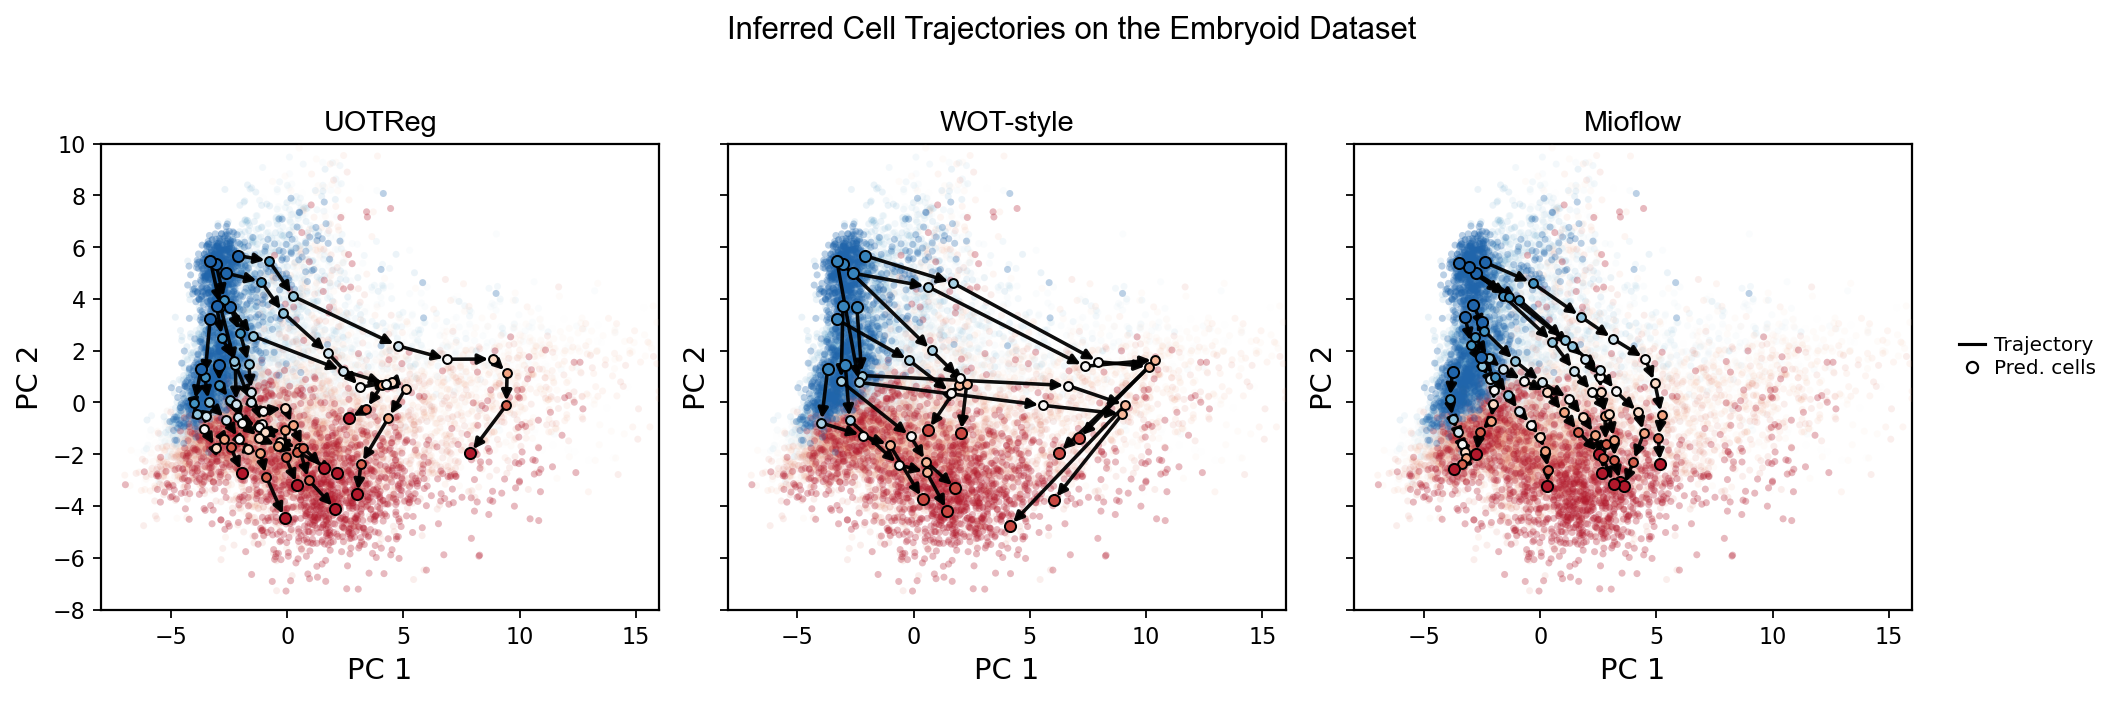

In [25]:
marker_sizes = {
    'Day 2': 10,
    'Day 3 (predicted)': 10,
    'Day 4 (predicted)': 10,
    'Day 5 (predicted)': 10,
    'Day 6': 10,
}

plot_traj_1x3_harmonized(
    traj_list=[trajectory, trajectory_2, trajectory_3],
    titles=["UOTReg", "WOT-style", "Mioflow"],
    suptitle="Inferred Cell Trajectories on the Embryoid Dataset",
    # background
    bg_data_dict=data_dict,
    bg_time_labels=time_labels,
    bg_color_dict=color_dict,
    bg_sizes=marker_sizes,
    bg_alphas=alpha_values,
    bg_orders=z_orders,
    # per-panel node colors
    per_panel_step_labels=[trajectory_time_labels,
                           trajectory_time_labels_2,
                           trajectory_time_labels_3],
    per_panel_step_colors=[color_dict, color_dict_2, color_dict_3],
    # view & style
    xlim=(-8, 16), ylim=(-8, 10),
    start_size=25, mid_size=16, end_size=25,
    spine_lw=1.0, tick_size=10, label_size=13, title_size=13,
    figsize=(13.5, 4.4), dpi=160,
    right_margin=0.90, legend_anchor_x=0.905, legend_fontsize=9,
    fontfamily="Arial",
    arrow_lw=1.6, arrow_ms=9, point_edge_lw=0.9,
    skip_indices=[3]  # mirrors your "if(i==3): continue"
)
